# Multitemporal satellite images via Sentinel hub API 

One of the most important step when collecting our satellite images is collecting satellite images from multiple timestamps. In order to determine the deforestation in an certaain area, we need satellite images of the same scene (area) from  different timestamps.
In this notebook we will be doing the following steps:

* Using SentinelHubCatalo to search for avaailable satellite images from desired timestamps and bbox.
* Search if desired timestamp is available
* Search and download  for available images of an area/bbox from mulltiple timestamps
* Plot satellite images

**In this notebook we will  be using this bbox : [86.773796,21.848934,87.231445,22.063497]**

In [1]:
from python_scripts.connector import *
from python_scripts.helper import *

Succefully connected!


In [2]:
from eval_scripts.evalscript_true_color import *
from eval_scripts.evalscript_forest import *
from eval_scripts.evalscript_ndvi import *

In [5]:
# Import necessary libraries
from sentinelhub import MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient,DataCollection, bbox_to_dimensions, SHConfig

## Using SentinelHubCatalo to search for avaailable satellite images from desired timestamps and bbox.

In [7]:
from sentinelhub import SentinelHubCatalog

In [8]:
catalog = SentinelHubCatalog(config= config)

In [9]:
bbox = BBox([86.773796,21.848934,87.231445,22.063497], crs=CRS.WGS84)
time_interval = '2017-01-01', '2020-01-01'

In [10]:
search_iterator = catalog.search(
    DataCollection.SENTINEL2_L2A,
    bbox=bbox,
    time=time_interval,
    query={
        "eo:cloud_cover": {
            "lt": 10
        }
    },
    fields={
        "include": [
            "id",
            "properties.datetime",
            "properties.eo:cloud_cover"
        ],
        "exclude": []
    }

)

results = list(search_iterator)
print('Total number of results:', len(results))

results

Total number of results: 355


[{'id': 'S2A_MSIL2A_20191231T044201_N0213_R033_T45QVE_20191231T083447',
  'properties': {'datetime': '2019-12-31T04:52:30Z', 'eo:cloud_cover': 0.0}},
 {'id': 'S2A_MSIL2A_20191231T044201_N0213_R033_T45QWE_20191231T083447',
  'properties': {'datetime': '2019-12-31T04:52:27Z', 'eo:cloud_cover': 0.0}},
 {'id': 'S2B_MSIL2A_20191229T045209_N0213_R076_T45QVE_20191229T085126',
  'properties': {'datetime': '2019-12-29T05:02:26Z', 'eo:cloud_cover': 0.0}},
 {'id': 'S2A_MSIL2A_20191224T045211_N0213_R076_T45QVE_20191224T074728',
  'properties': {'datetime': '2019-12-24T05:02:25Z', 'eo:cloud_cover': 0.0}},
 {'id': 'S2B_MSIL2A_20191219T045209_N0213_R076_T45QVE_20191219T082251',
  'properties': {'datetime': '2019-12-19T05:02:25Z', 'eo:cloud_cover': 0.0}},
 {'id': 'S2A_MSIL2A_20191214T045211_N0213_R076_T45QVE_20191214T071044',
  'properties': {'datetime': '2019-12-14T05:02:26Z', 'eo:cloud_cover': 0.18}},
 {'id': 'S2A_MSIL2A_20191211T044201_N0213_R033_T45QVE_20191211T070257',
  'properties': {'datetime'

## Search and download for available images of an area/bbox from mulltiple timestamps

#### Search if desired timestamp is available

In [11]:
import datetime

In [12]:
'2017-01-01', '2020-01-01'
start = datetime.datetime(2017,1,1)
end = datetime.datetime(2022, 1, 1)
n_chunks = 5
tdelta = (end - start) / n_chunks
edges = [(start + i*tdelta).date().isoformat() for i in range(n_chunks)]
slots = [(edges[i], edges[i+1]) for i in range(len(edges)-1)]

print("Yearly time windows")
for slot in slots:
    print(slot)

Yearly time windows
('2017-01-01', '2018-01-01')
('2018-01-01', '2019-01-01')
('2019-01-01', '2020-01-01')
('2020-01-01', '2020-12-31')


In [13]:
resolution = 60
betsiboka_bbox = BBox(bbox=bbox, crs=CRS.WGS84)
betsiboka_size = bbox_to_dimensions(betsiboka_bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: {betsiboka_size} pixels')

Image shape at 60 m resolution: (788, 396) pixels


In [14]:
evalscript_true_color = """
    //VERSION=3
    function setup() {
        return {
            input: [{ bands: ["B02", "B03", "B04"] }],
            output: { bands: 3 }
        };
    }
    function evaluatePixel(sample) {
      return [2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02];
    }
"""

In [15]:
def get_true_color_request(time_interval):
    return SentinelHubRequest(
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=time_interval,
                mosaicking_order='leastCC'
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.PNG)
        ],
        bbox=betsiboka_bbox,
        size=betsiboka_size,
        config=config
    )

In [16]:
# create a list of requests
list_of_requests = [get_true_color_request(slot) for slot in slots]
list_of_requests = [request.download_list[0] for request in list_of_requests]

# download data with multiple threads
data = SentinelHubDownloadClient(config=config).download(list_of_requests, max_threads=5)

## Plot satellite images

In [17]:
import matplotlib.pyplot as plt
import numpy as np

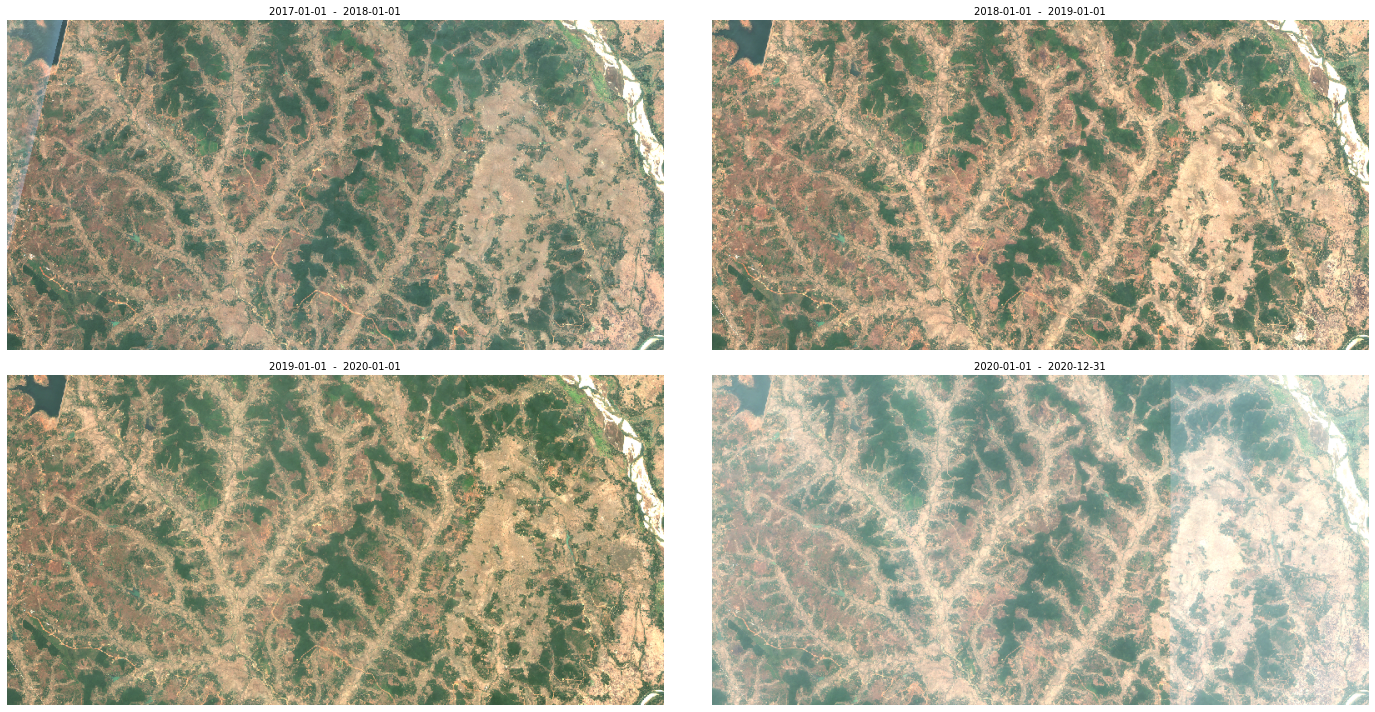

In [18]:
# some stuff for pretty plots
ncols = 2
nrows = 2
aspect_ratio = betsiboka_size[0] / betsiboka_size[1]
subplot_kw = {'xticks': [], 'yticks': [], 'frame_on': False}

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols * aspect_ratio, 5 * nrows),
                        subplot_kw=subplot_kw)

for idx, image in enumerate(data):
    ax = axs[idx // ncols][idx % ncols]
    ax.imshow(np.clip(image * 2.5/255, 0, 1))
    ax.set_title(f'{slots[idx][0]}  -  {slots[idx][1]}', fontsize=10)

plt.tight_layout()